In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imodelsx import embgam
from datasets import load_dataset
from sklearn.base import ClassifierMixin, RegressorMixin
import pandas as pd
from preprocess import clean_headlines, sample_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def predict(model, X, warn=True):
    """For regression returns continuous output.
    For classification, returns discrete output.
    """
    preds = _predict_cached(model, X, warn=warn)
    if isinstance(model, RegressorMixin):
        return preds
    elif isinstance(model, ClassifierMixin):
        if preds.ndim > 1:  # multiclass classification
            return np.argmax(preds, axis=1)
        return ((preds + model.linear.intercept_) > 0).astype(int)


def _predict_cached(model, X, warn):
    """Predict only the cached coefs in model.coefs_dict_"""
    assert hasattr(model, "coefs_dict_"), "coefs are not cached!"
    preds = []
    n_unseen_ngrams = 0
    for x in X:
        pred = np.zeros(len(model.classes_))
        seqs = embgam.embed.generate_ngrams_list(
            x,
            ngrams=model.ngrams,
            tokenizer_ngrams=model.tokenizer_ngrams,
            all_ngrams=model.all_ngrams,
        )
        for seq in seqs:
            if seq in model.coefs_dict_:
                pred += model.coefs_dict_[seq]
            else:
                n_unseen_ngrams += 1
        preds.append(pred)

    return np.array(preds)

In [8]:
# load data
with open(f"Data/huffpost.pkl", "rb") as f:
    huffpost_data = pkl.load(f)

huffpost_data = clean_headlines(huffpost_data)

# load model
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018]
res = np.zeros((len(years), len(years)))
std = np.zeros((len(years), len(years)))
for i, train_year in enumerate([years]):
    for j, test_year in enumerate(years):
        test_data, test_labels = sample_data(huffpost_data, year=test_year, in_dist=False, frac=1)

        if train_year == test_year:
            with open(f"models/huffpost_{train_year}_embgam_ngrams=2.pkl", "rb") as f:
                m = pkl.load(f)
            preds = predict(m, test_data)
            res[i, j] = np.mean(preds == test_labels)
            std[i, j] = 0

        else:
            try:
                acc = []
                for seed in [42, 192, 852, 5555]:
                    with open(f"models/expt2/expt2_train_{train_year}_test_{test_year}_seed_{seed}.pkl", "rb") as f:
                        m = pkl.load(f)

                    # predict
                    preds = predict(m, test_data)
                    acc.append(np.mean(preds == test_labels))
                res[i,j] = np.mean(acc)
                std[i,j] = np.std(acc)
            except:
                print(f"No data for train year {train_year} and test year {test_year}")
                continue

/Users/aaskari/.pyenv/versions/3.9.7/envs/emb-gam/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 1.2.0 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No data for train year 2016 and test year 2015
No data for train year 2016 and test year 2017
No data for train year 2016 and test year 2018
No data for train year 2017 and test year 2012
No data for train year 2017 and test year 2013
No data for train year 2017 and test year 2014
No data for train year 2017 and test year 2015
No data for train year 2017 and test year 2016
No data for train year 2017 and test year 2018
No data for train year 2018 and test year 2012
No data for train year 2018 and test year 2013
No data for train year 2018 and test year 2014
No data for train year 2018 and test year 2015
No data for train year 2018 and test year 2016
No data for train year 2018 and test year 2017


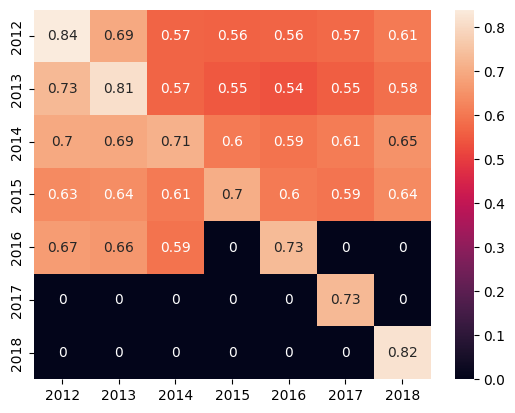

In [10]:
df = pd.DataFrame(data=res, index=years, columns=years)
sns.heatmap(df, annot=True)
plt.show()